In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import optuna

<h1>Maternal Health Risk Data<h1>

In [8]:
file_path = "Maternal Health Risk Data Set.csv"
df = pd.read_csv(file_path)
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [9]:
# Encode target variable
encoder = OrdinalEncoder(categories=[['low risk', 'mid risk', 'high risk']])
df['RiskLevel'] = encoder.fit_transform(df[['RiskLevel']]).astype(int)

In [11]:
print(df["RiskLevel"].value_counts())

RiskLevel
0    406
1    336
2    272
Name: count, dtype: int64


In [13]:
# Feature-target split
X = df.drop(columns=['RiskLevel'])
y = df['RiskLevel']

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0
RiskLevel,1014.0,0.867850,0.807353,0.0,0.0,1.0,2.0,2.0


<h3>Correlation Analysis of Variables</h3>

In [18]:
# Map RiskLevel to integer values
risk_mapping = {"low risk": 0, "mid risk": 1, "high risk": 2}
df["RiskLevel"] = df["RiskLevel"].map(risk_mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    0 non-null      float64
dtypes: float64(3), int64(4)
memory usage: 55.6 KB


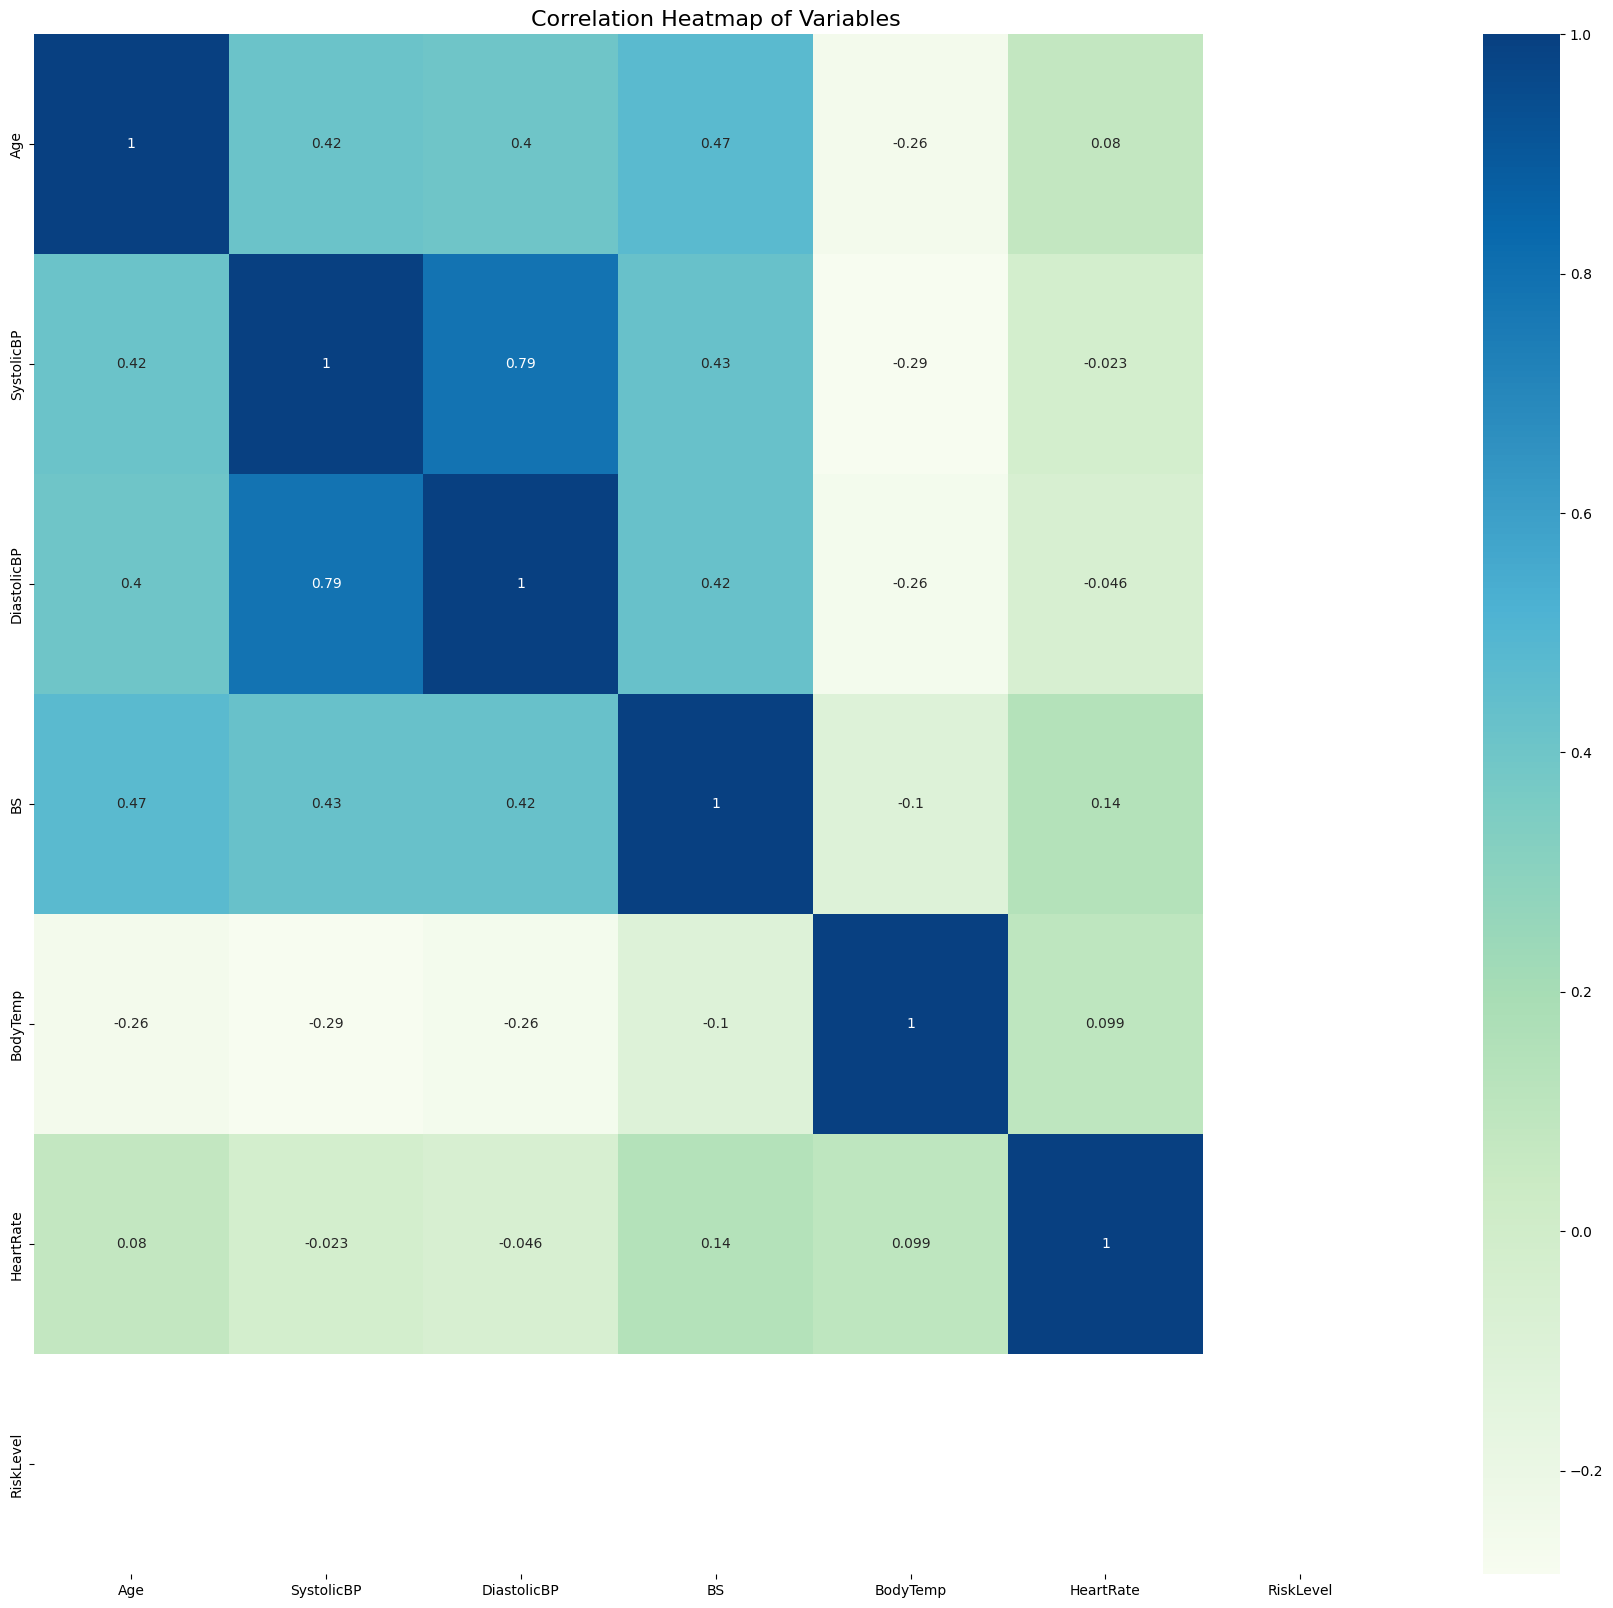

In [19]:
# Create a correlation heatmap
plt.figure(figsize=(22,20))  
sns.heatmap(df.corr(), annot=True, cmap = "GnBu")
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.savefig("maternal_heat_map_to_check_correlation.png")
plt.show()

SystolicBP and DiastolicBP show a high positive correlation (correlation coefficient = 0.79), indicating multicollinearity. This suggests redundancy in information between these two variables.

In [13]:
X = m_df[["SystolicBP", "DiastolicBP"]]

,Variable,VIF
0,SystolicBP,79.96833
1,DiastolicBP,79.96833


In [21]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Identify the outlier in HeartRate
df.HeartRate.sort_values().head()

908     7
499     7
702    60
783    60
784    60
Name: HeartRate, dtype: int64

In [23]:
# Define optimization function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }
    model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

<h3>Model Building</h3>

In [27]:
# Train best model
best_model = XGBClassifier(**best_params, random_state=42, eval_metric='mlogloss')
best_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8934119480014404, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1901227425187292,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
# Predictions
y_pred = best_model.predict(X_test)

In [30]:
# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[68 11  2]
 [ 9 53  5]
 [ 2  0 53]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        81
           1       0.83      0.79      0.81        67
           2       0.88      0.96      0.92        55

    accuracy                           0.86       203
   macro avg       0.86      0.86      0.86       203
weighted avg       0.86      0.86      0.86       203



In [31]:
joblib.dump(scale_X, 'scaleX.pkl')
X.head()

NameError: name 'joblib' is not defined

In [20]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((809, 5), (203, 5), (809,), (203,))

**Logistic Regression**

In [21]:
# Baseline model of Logistic Regression
logistic_regression = linear_model.LogisticRegression()
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
print(f"Baseline Logistic Regression: {round(logistic_regression_mod.score(X_test, y_test), 3)}")
pred_logistic_regression = logistic_regression_mod.predict(X_test)

Baseline Logistic Regression: 0.64


In [22]:
# Cross validate Logistic Regression model
scores_Logistic = cross_val_score(logistic_regression, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for Logistic Regression model:\n{scores_Logistic}")
print(f"CrossValMeans: {round(scores_Logistic.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_Logistic.std(), 3)}")

Scores(Cross validate) for Logistic Regression model:
[0.6037037  0.5962963  0.57992565]
CrossValMeans: 0.593
CrossValStandard Deviation: 0.01


In [23]:
params_LR = {"tol": [0.0001,0.0002,0.0003],
            "C": [0.01, 0.1, 1, 10, 100],
            "intercept_scaling": [1, 2, 3, 4],
            "solver": ["liblinear", "lbfgs", "newton-cg"],
            "max_iter": [100, 200, 300],
              }

In [24]:
GridSearchCV_LR = GridSearchCV(estimator=linear_model.LogisticRegression(), 
                                param_grid=params_LR, 
                                cv=3,
                                scoring="accuracy", 
                                return_train_score=True,
                                )

In [25]:
GridSearchCV_LR.fit(X_train, y_train);

In [26]:
print(f"Best estimator for LR model:\n{GridSearchCV_LR.best_estimator_}")
print(f"Best parameter values for LR model:\n{GridSearchCV_LR.best_params_}")
print(f"Best score for LR model: {round(GridSearchCV_LR.best_score_, 3)}")

Best estimator for LR model:
LogisticRegression(C=0.01, solver='liblinear')
Best parameter values for LR model:
{'C': 0.01, 'intercept_scaling': 1, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Best score for LR model: 0.602


In [27]:
# Test with new parameter
logistic_regression = linear_model.LogisticRegression(C=0.01, intercept_scaling=1, max_iter=100, solver="liblinear", tol=0.0001, random_state=42)
logistic_regression_mod = logistic_regression.fit(X_train, y_train)
pred_logistic_regression = logistic_regression_mod.predict(X_test)

mse_logistic_regression = mean_squared_error(y_test, pred_logistic_regression)
rmse_logistic_regression = np.sqrt(mean_squared_error(y_test, pred_logistic_regression))
score_logistic_regression_train = logistic_regression_mod.score(X_train, y_train)
score_logistic_regression_test = logistic_regression_mod.score(X_test, y_test)

In [28]:
print(f"Mean Square Error for Logistic Regression = {round(mse_logistic_regression, 3)}")
print(f"Root Mean Square Error for Logistic Regression = {round(rmse_logistic_regression, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_logistic_regression_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_logistic_regression_test, 3)}")

Mean Square Error for Logistic Regression = 0.512
Root Mean Square Error for Logistic Regression = 0.716
R^2(coefficient of determination) on training set = 0.609
R^2(coefficient of determination) on testing set = 0.635


In [29]:
print("Classification Report")
print(classification_report(y_test, pred_logistic_regression))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_logistic_regression))

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.88      0.70        81
           1       0.56      0.21      0.30        67
           2       0.77      0.80      0.79        55

    accuracy                           0.64       203
   macro avg       0.64      0.63      0.60       203
weighted avg       0.63      0.64      0.59       203

Confusion Matrix:
[[71  6  4]
 [44 14  9]
 [ 6  5 44]]


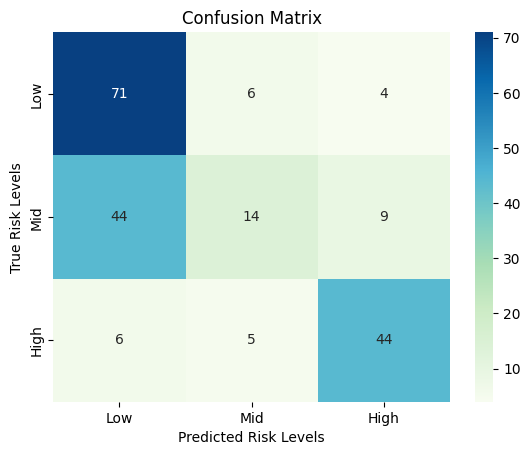

In [30]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, pred_logistic_regression), annot=True, ax=ax, cmap = "GnBu");

ax.set_xlabel("Predicted Risk Levels");
ax.set_ylabel("True Risk Levels");  
ax.set_title("Confusion Matrix"); 
ax.xaxis.set_ticklabels(["Low", "Mid", "High"]);
ax.yaxis.set_ticklabels(["Low", "Mid", "High"]);

**K-Nearest Neighbors**

In [31]:
# Baseline model of K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_mod = knn.fit(X_train, y_train)
print(f"Baseline K-Nearest Neighbors: {round(knn_mod.score(X_test, y_test), 3)}")
pred_knn = knn_mod.predict(X_test)

Baseline K-Nearest Neighbors: 0.66


In [32]:
# Cross validate K-Nearest Neighbors model
scores_knn = cross_val_score(knn, X_train, y_train, cv=3, scoring="accuracy")
print(f"Scores(Cross validate) for K-Nearest Neighbors model:\n{scores_knn}")
print(f"CrossValMeans: {round(scores_knn.mean(), 3)}")
print(f"CrossValStandard Deviation: {round(scores_knn.std(), 3)}")

Scores(Cross validate) for K-Nearest Neighbors model:
[0.61481481 0.66666667 0.64684015]
CrossValMeans: 0.643
CrossValStandard Deviation: 0.021


In [33]:
params_knn = {"leaf_size": list(range(1,30)),
              "n_neighbors": list(range(1,21)),
              "p": [1,2],
              "weights": ["uniform", "distance"],
             }

In [34]:
GridSearchCV_knn = GridSearchCV(estimator=KNeighborsClassifier(), 
                                param_grid=params_knn,
                                cv=3,
                                scoring="accuracy",
                                return_train_score=True
                                )

In [35]:
# Fit model with train data
GridSearchCV_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [36]:
print(f"Best estimator for KNN model:\n{GridSearchCV_knn.best_estimator_}")
print(f"Best parameter values:\n{GridSearchCV_knn.best_params_}")
print(f"Best score for GNB model: {round(GridSearchCV_knn.best_score_, 3)}")

Best estimator for KNN model:
KNeighborsClassifier(leaf_size=1, n_neighbors=10, weights='distance')
Best parameter values:
{'leaf_size': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best score for GNB model: 0.795


In [40]:
# Test with new parameter
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights="distance")
knn_mod = knn.fit(X_train, y_train)
pred_knn = knn_mod.predict(X_test)

mse_knn = mean_squared_error(y_test, pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, pred_knn))
score_knn_train = knn_mod.score(X_train, y_train)
score_knn_test = knn_mod.score(X_test, y_test)

In [41]:
print(f"Mean Square Error for K_Nearest Neighbor  = {round(mse_knn, 3)}")
print(f"Root Mean Square Error for K_Nearest Neighbor = {round(rmse_knn, 3)}")
print(f"R^2(coefficient of determination) on training set = {round(score_knn_train, 3)}")
print(f"R^2(coefficient of determination) on testing set = {round(score_knn_test, 3)}")

Mean Square Error for K_Nearest Neighbor  = 0.251
Root Mean Square Error for K_Nearest Neighbor = 0.501
R^2(coefficient of determination) on training set = 0.934
R^2(coefficient of determination) on testing set = 0.837


In [42]:
print("Classification Report")
print(classification_report(y_test, pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        81
           1       0.77      0.85      0.81        67
           2       0.88      0.93      0.90        55

    accuracy                           0.84       203
   macro avg       0.84      0.85      0.84       203
weighted avg       0.84      0.84      0.84       203

Confusion Matrix:
[[62 17  2]
 [ 5 57  5]
 [ 4  0 51]]


In [33]:
import joblib

# Save the trained model
joblib.dump(best_model, "finalized_maternal_model.sav")

# Save the scaler
joblib.dump(scaler, "scaleX.pkl")


['scaleX.pkl']